# ASSIST: publication figures

Here we regenerate the figures for the ASSIST publication one place.  This allows ASSIST to see exactly how those figures were made.

This notebook assumes that you have install ASSIST and the ephemeris files. If you are unfamiliar with ASSIST, we suggest that you first look at the "Getting started" notebook.

First, let's import REBOUND, ASSIST as well as numpy and matplotlib.

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import assist 
au2m = 149597870700

Next, we create an ephemeris structure. ASSIST will use this structure to access the JPL Ephemeris files during the integrations. Depending on where you have stored the files, you might need to adjust the paths.

In [31]:
ephem = assist.Ephem("../data/linux_p1550p2650.440", "../data/sb441-n16.bsp")

In [32]:
sim = rebound.Simulation()
holman_initial = rebound.Particle(
    x=3.338875348598862E+00, y=-9.176518412197102E-01, z=-5.038590741719294E-01, 
    vx=2.805663364339457E-03, vy=7.550408665778840E-03, vz=2.980028207875623E-03)
sim.add(holman_initial)

scale=1e-8
sim.add(holman_initial + rebound.Particle(x=scale))
sim.add(holman_initial + rebound.Particle(y=scale))
sim.add(holman_initial + rebound.Particle(z=scale))
sim.add(holman_initial + rebound.Particle(vx=scale))
sim.add(holman_initial + rebound.Particle(vy=scale))
sim.add(holman_initial + rebound.Particle(vz=scale))

ex = assist.Extras(sim, ephem)

In [33]:
var = sim.add_variation(testparticle=0)
var.particles[0].x = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].y = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].z = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vx = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vy = 1.0

var = sim.add_variation(testparticle=0)
var.particles[0].vz = 1.0

In [34]:
trange = 10_000
N = 500 # number of outputs
times = np.linspace(sim.t, sim.t+trange, N)

pos_holman = np.zeros((N,7,3))
pos_holman_per = np.zeros((N,6,3))
pos_holman_var = np.zeros((N,6,3))

for i in range(N):
    ex.integrate_or_interpolate(times[i])
    for j in range(7):
        pos_holman[i,j] = sim.particles[j].xyz
    for j in range(6):
        pos_holman_var[i,j] = sim.particles[7+j].xyz

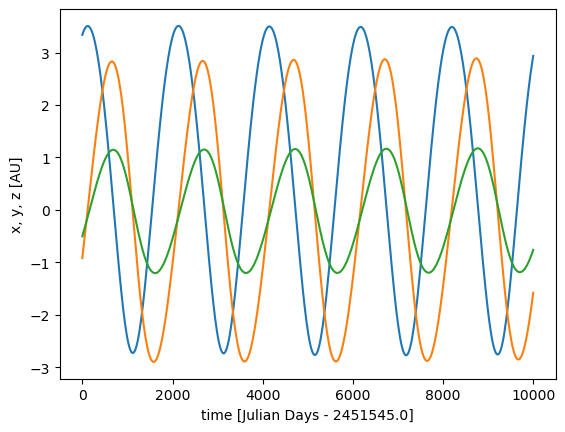

In [35]:
fig, ax = plt.subplots()
ax.set_xlabel("time [Julian Days - %.1f]"%ephem.jd_ref)
ax.set_ylabel("x, y, z [AU]")
ax.plot(times, pos_holman[:,0,:]);

In [8]:
pos_holman.shape

(500, 7, 3)

Text(0, 0.5, 'AU')

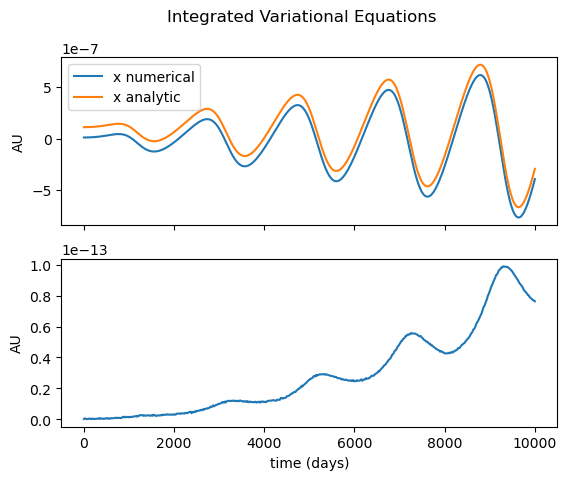

In [26]:
scale=1e-8
fig, axs = plt.subplots(2)
fig.suptitle('Integrated Variational Equations')

axs[0].plot(times, (pos_holman[:,1,:]-pos_holman[:,0,:])[:,0], label='x numerical')
axs[0].plot(times, pos_holman_var[:,0,0]*scale+1e-7, label='x analytic')
axs[0].set_ylabel("AU")
axs[0].legend()
axs[0].label_outer()

axs[1].plot(times, np.linalg.norm((pos_holman[:,1,:]-pos_holman[:,0,:]-pos_holman_var[:,0,:]*scale), axis=1))
axs[1].set_xlabel("time (days)")
axs[1].set_ylabel("AU")
#plt.savefig('numerical_vs_analytic_2panel.pdf')

In [114]:
ex.detach(sim)

del(sim)

In [116]:
sim = rebound.Simulation()
holman_initial = rebound.Particle(
    x=3.338875348598862E+00, y=-9.176518412197102E-01, z=-5.038590741719294E-01, 
    vx=2.805663364339457E-03, vy=7.550408665778840E-03, vz=2.980028207875623E-03)
sim.add(holman_initial)

ex = assist.Extras(sim, ephem)

In [117]:
t0 = 2458849.5-ephem.jd_ref;
sim.t = t0
trange =100_000
sim.dt = 20
sim.integrate(t0+trange)

In [118]:
sim.dt = -20
sim.integrate(t0)

In [119]:
sim.dt

-15.183064181818073

In [120]:
np.linalg.norm((sim.particles[0]-holman_initial).xyz)*au2m

4.159941999427266

In [147]:
def round_trip(trange):
    sim = rebound.Simulation()
    t0 = 2458849.5-ephem.jd_ref;
    x0=3.338875348598862E+00
    y0=-9.176518412197102E-01
    z0=-5.038590741719294E-01
    vx0=2.805663364339457E-03
    vy0=7.550408665778840E-03
    vz0=2.980028207875623E-03
    holman_initial = rebound.Particle(x=x0, y=y0, z=z0, vx=vx0, vy=vy0, vz=vz0)
    sim.add(holman_initial)
    ex = assist.Extras(sim, ephem)
    
    sim.t=t0
    sim.dt=20
    sim.integrate(t0+trange)
    
    sim.dt *=-1
    sim.integrate(t0)
    
    d = np.linalg.norm((sim.particles[0]-holman_initial).xyz)*au2m
    
    ex.detach(sim)
    del(sim)
    
    return(d)

In [149]:
results=[]
for trange in np.logspace(0, 5, num=30):
    results.append((trange, round_trip(trange)))

1.0
1.4873521072935114
2.2122162910704493
3.2903445623126686
4.893900918477494
7.278953843983151
10.826367338740546
16.102620275609393
23.95026619987486
35.622478902624444
52.9831690628371
78.80462815669912
117.21022975334806
174.3328822199989
259.2943797404667
385.6620421163472
573.6152510448682
853.1678524172814
1268.9610031679233
1887.3918221350978
2807.2162039411787
4175.318936560405
6210.169418915616
9236.708571873865
13738.237958832638
20433.59717856944
30391.95382313201
45203.5365636025
67233.57536499335
100000.0


In [157]:
t = np.array(list(map(lambda x: x[0], results)))
dx = list(map(lambda x: x[1], results))

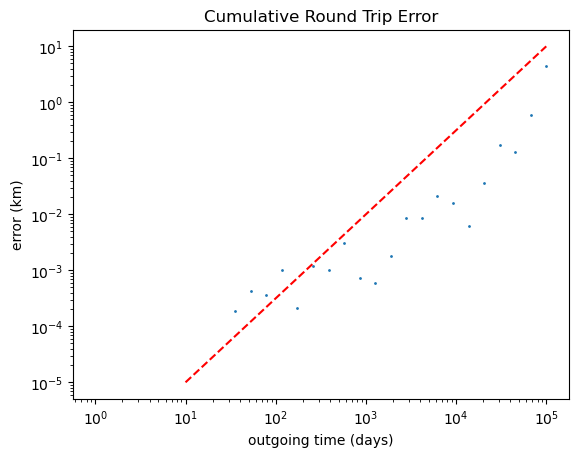

In [158]:
plt.scatter(t[:], dx[:], s=1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('outgoing time (days)')
plt.ylabel('error (km)')
plt.title('Cumulative Round Trip Error')
plt.plot((1e1,1e5), (1e-5,1e+1), '--', c='r')
#plt.savefig('roundtrip_Holman.pdf')